#ARMA - AAPL data

**Notebook Summary**

**Data**: AAPL

**Granularity**: daily data

**Source**: Yahoo! Finance

**Time period**: 2010-01-04 / 2022-12-30

**Models**: ARMA, ARMA-GARCH


# Importing Libraries

In [ ]:
# Importing models
!pip install arch
!pip install pmdarima

# Importing libraries
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import io
import scipy as sc
import statsmodels.api as sm
import sklearn
import seaborn as sns
import statsmodels.api as sm
from arch import arch_model
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose as sd
from sklearn.metrics import mean_squared_error
from scipy.stats import norm
import pmdarima as pm
from pmdarima.arima.utils import ndiffs
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf


# Plot
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
sns.set()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import files
uploaded = files.upload()

# Load Data

In [ ]:
# Daily data
data = pd.read_csv(io.BytesIO(uploaded['AAPL.csv']))

In [ ]:
data_new = data.copy()

# Exploratory analysis

In [ ]:
# Compute the log returns for AAPL stock using .diff()
log_returns = np.log(data["Adj Close"]).diff(1)
data["log_returns"] = log_returns

# Set the time index
data["Date"] = pd.to_datetime(data["Date"])
data.set_index("Date", inplace = True)

In [ ]:
data.head()

,Open,High,Low,Close,Adj Close,Volume,log_returns
Date,,,,,,,
2010-01-04,7.622500,7.660714,7.585000,7.643214,6.505280,493729600,NaN
2010-01-05,7.664286,7.699643,7.616071,7.656429,6.516528,601904800,0.001728
2010-01-06,7.656429,7.686786,7.526786,7.534643,6.412874,552160000,-0.016034
2010-01-07,7.562500,7.571429,7.466071,7.520714,6.401018,477131200,-0.001850
2010-01-08,7.510714,7.571429,7.466429,7.570714,6.443573,447610800,0.006626


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3272 entries, 2010-01-04 to 2022-12-30
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Open         3272 non-null   float64
 1   High         3272 non-null   float64
 2   Low          3272 non-null   float64
 3   Close        3272 non-null   float64
 4   Adj Close    3272 non-null   float64
 5   Volume       3272 non-null   int64  
 6   log_returns  3271 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 204.5 KB


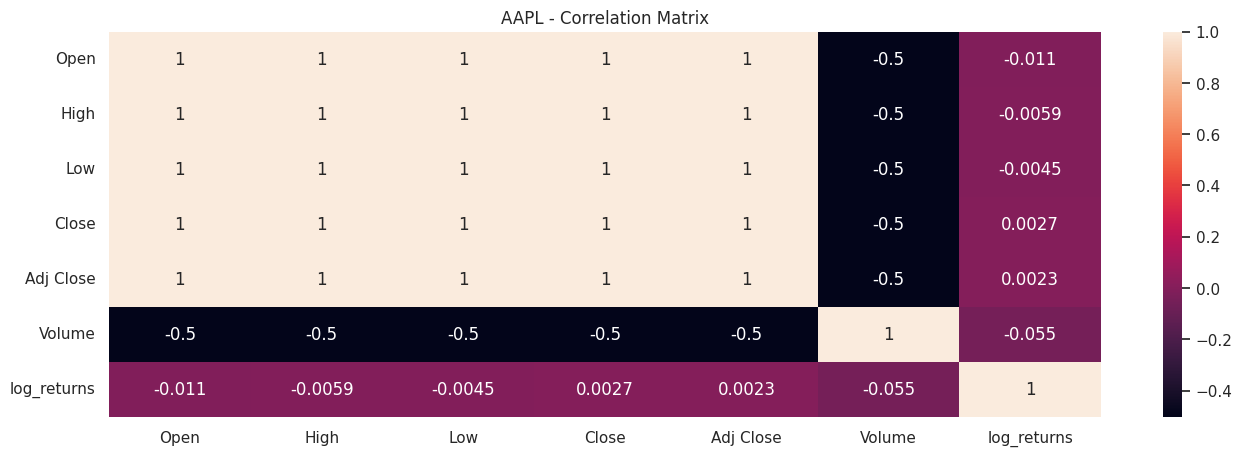

In [ ]:
# Get the correlation matrix between features
corr = data.corr()

# Plot it as a heatmap
sns.heatmap(corr, annot= True)
plt.title("AAPL - Correlation Matrix")
plt.show()

Text(0.5, 1.0, 'QQ Plot AAPL returns')

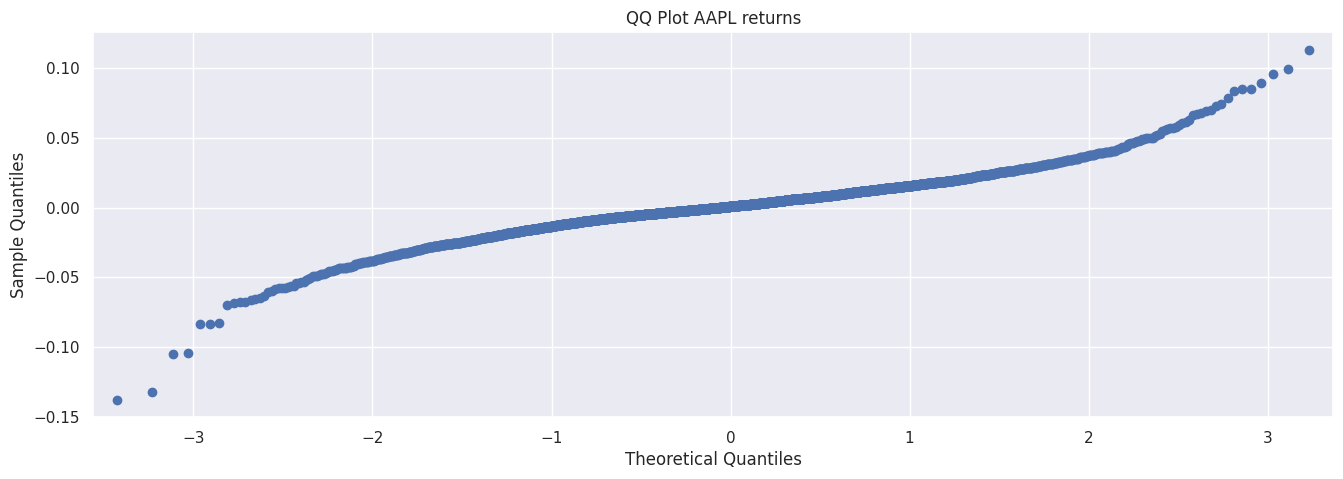

In [ ]:
# Plot the Q-Q plot for log returns
from statsmodels.graphics.gofplots import qqplot as qq
qq_plot = qq(data['log_returns'], line='s')
plt.title('QQ Plot AAPL returns')

In [ ]:
# Get summary statistics of the data
mean = data['log_returns'].mean()
std = data['log_returns'].std()
skew = data['log_returns'].skew()
kurtosis = data['log_returns'].kurtosis()

print("Mean: ", mean,
      "\nStandard Deviation:", std,
      "\nSkewness:", skew,
      "\nKurtosis:", kurtosis)

Mean:  0.0009149666759937635 
Standard Deviation: 0.018100405912422374 
Skewness: -0.2518478527826582 
Kurtosis: 5.367899323779924


Given that the kurtosis is bigger than 3 (normal distribution), we conclude that the tails of AAPL log returns distribution are heavier.

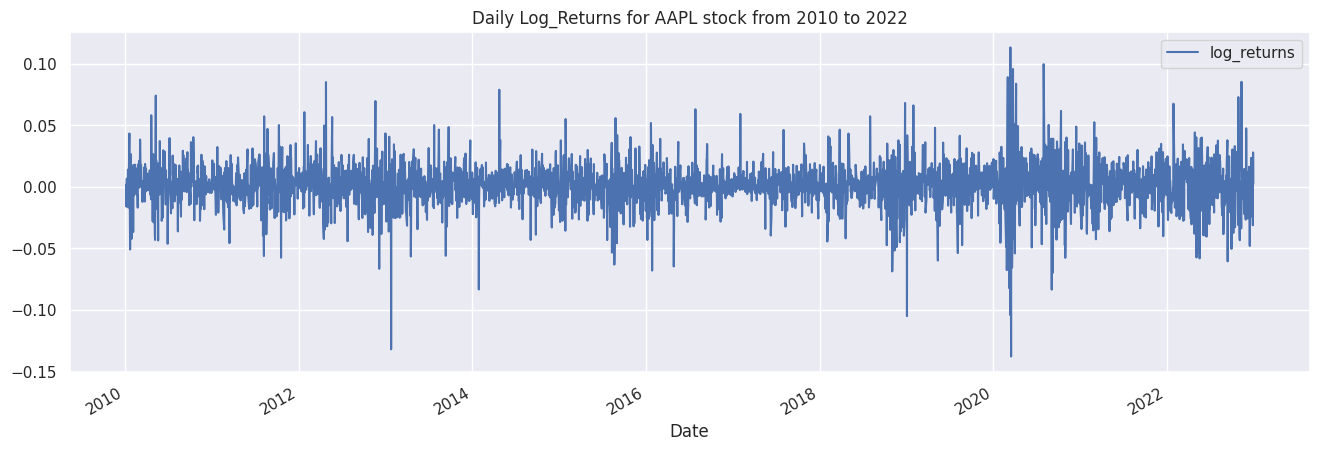

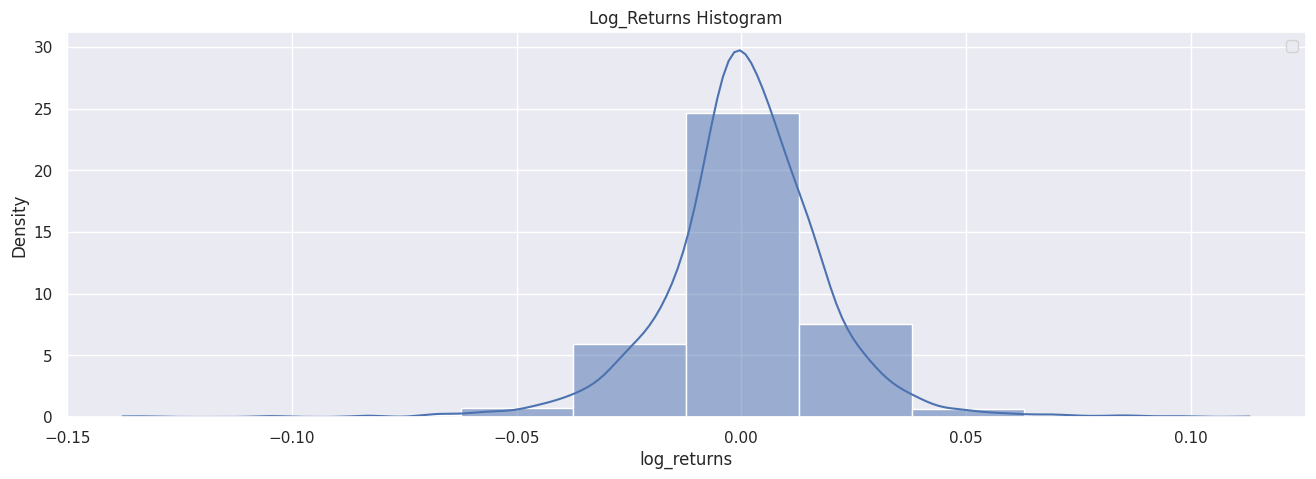

In [ ]:
# Plot the log_returns
x = np.linspace(-10,10,1000)
data.plot(y = "log_returns", title = "Daily Log_Returns for AAPL stock from 2010 to 2022", legend = True)
plt.show()

# Plot the histogram and kde
sns_ax = sns.histplot(data = data, x = "log_returns", bins=10, stat="density", kde=True)
sns_ax.set_title("Log_Returns Histogram")
plt.legend()
plt.show()


# Refine Dataset

In [ ]:
data = data[['log_returns']]

In [ ]:
# Drop the first NaN observation
data = data.dropna()
data

,log_returns
Date,
2010-01-05,0.001728
2010-01-06,-0.016034
2010-01-07,-0.001850
2010-01-08,0.006626
2010-01-11,-0.008861
...,...
2022-12-23,-0.002802
2022-12-27,-0.013976
2022-12-28,-0.031166


# Train/Test split

In [ ]:
# Split data into train and test set
train_df = data.loc[:"2019-12-31"]
test_df = data.loc["2020-01-01":]
print(train_df.shape)
print(test_df.shape)

(2515, 1)
(756, 1)


#Decomposition of Time Series

<Figure size 2000x1800 with 0 Axes>

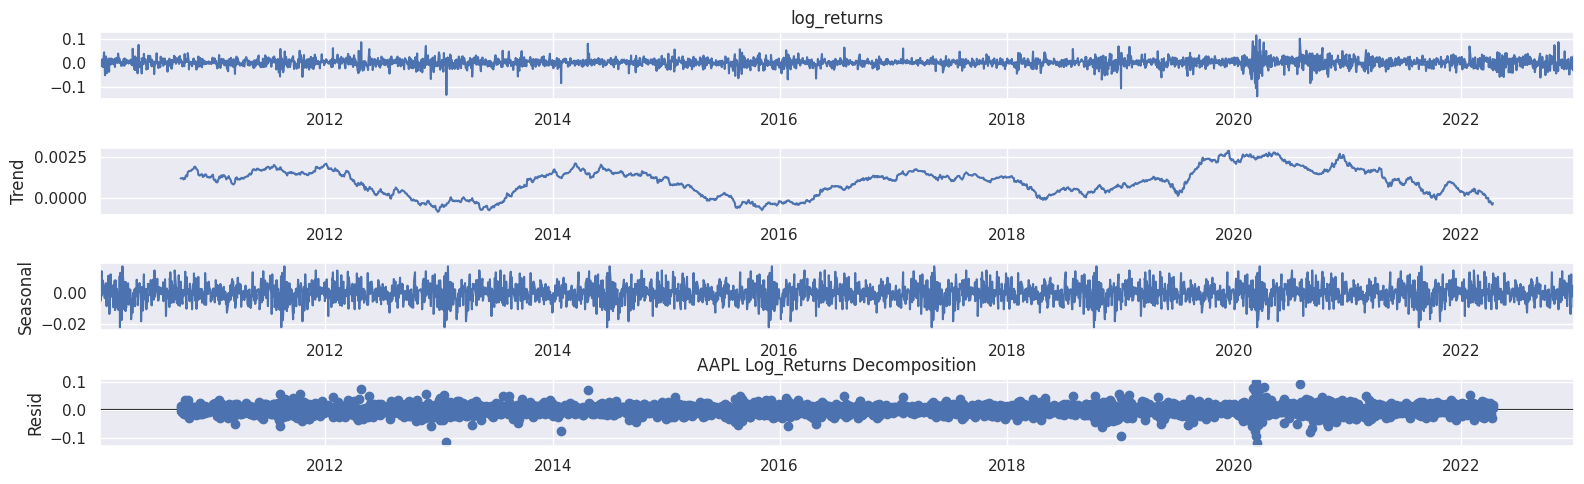

In [ ]:
# Plot the decomposition
plt.figure(figsize=(20,18))
decomposed_series = sd(data['log_returns'], model='additive', period = 360)
decomposed_series.plot()
plt.title("AAPL Log_Returns Decomposition")
plt.show()

# Stationarity of Time Series

Augmented Dickey-Fuller(**ADF**) Test

H0)Time series has a unit root - Non-stationary

H1)Time series does not have a unit root - Stationary

**Stationary** if we have constant mean,constant variance and No Trend and Seasonality.

In [ ]:
def ad_fuller_function(series):
  results = adfuller(series)
  print('ADF Statistic: %f' % results[0])
  print('p-value: %f' %results[1])
  print('Number of lags %f' %results[2])

  print('Critical Values:')
  for k, v in results[4].items():
	  print('\t%s: %.3f' % (k, v))

  if results[0] < results[4]['5%']:
    print('Reject H0 - Time Series is Stationary')
  else:
    print('Failed to Reject H0 - Time Series is Non-Stationary')

In [ ]:
ad_fuller_function(data)

ADF Statistic: -11.627309
p-value: 0.000000
Number of lags 21.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Reject H0 - Time Series is Stationary


As we expected, daily returns are stationary, meaning that there is a mean-reversion characteristic. The mean is around zero and the variance is non-constant.

In [ ]:
# Check stationarity of data using other statistical tests
y = data['log_returns']
# Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test
print("KPSS Test: ",ndiffs(y, test='kpss'))
# Phillips–Perron (PP) test:
print("PP Test: ",ndiffs(y, test='pp'))

KPSS Test:  0
PP Test:  0



*   Augmented Dickey Fuller Test (ADF): is Unit Root test for stationarity. Unit roots can cause unpredictable results in your time series analysis.
*   Kwiatkowski–Phillips–Schmidt–Shin (KPSS): test figures out if a time series is stationary around a mean or linear trend, or is non-stationary due to a unit root.
* Phillips–Perron Test (PP): is a Unit Root Test, it is a modification of the Dickey Fuller test, and corrects for autocorrelation and heteroscedasticity in the errors.

All these tests suggest than d should be zero, namley no differencing operation is required in this case; analogously one can use stock prices with one differencing to make them stationary.

# ACF-PACF Log Returns

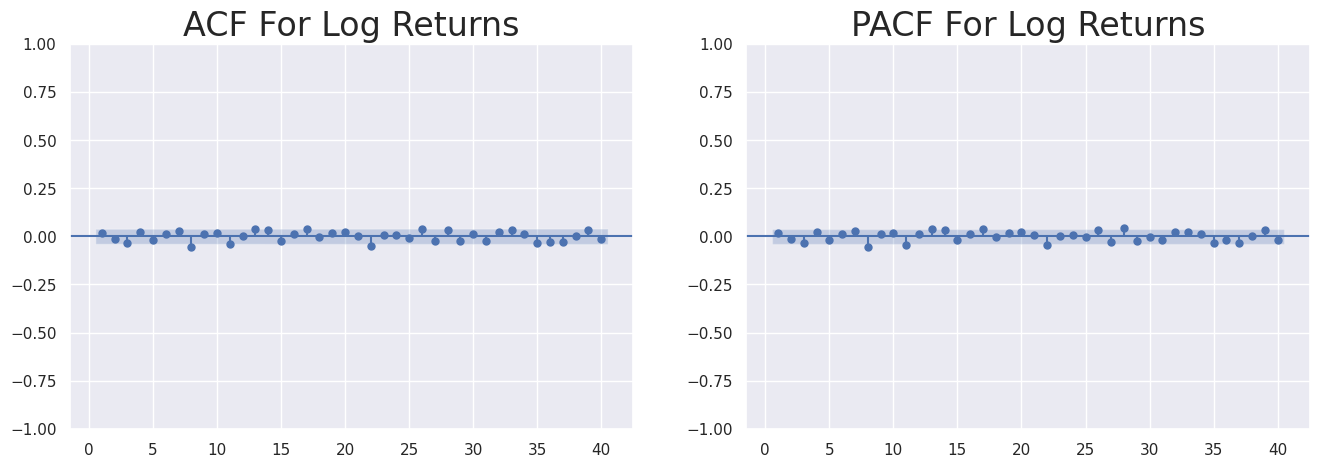

In [ ]:
plt.rcParams["figure.figsize"] = 16, 5
fig, axes = plt.subplots(1, 2)

sgt.plot_acf(train_df.log_returns[1:], zero = False, lags = 40, ax = axes[0])
sgt.plot_pacf(train_df.log_returns[1:], zero = False, lags = 40, ax = axes[1])

axes[0].set_title("ACF For Log Returns", size = 24)
axes[1].set_title("PACF For Log Returns", size = 24)

plt.show()

# ARMA

The ARMA(1,1) model is commonly used to fit log returns for stock price prediction due to its ability to capture both the autoregressive (AR) and moving average (MA) components of the time series.

In [ ]:
# Instantiate an ARMA(1,1) model and get the results
model = SARIMAX(train_df, order = (1, 0, 1))
model_results = model.fit()
print(model_results.summary())

                               SARIMAX Results                                
Dep. Variable:            log_returns   No. Observations:                 2515
Model:               SARIMAX(1, 0, 1)   Log Likelihood                6790.295
Date:                Sun, 11 Jun 2023   AIC                         -13574.591
Time:                        14:39:12   BIC                         -13557.101
Sample:                             0   HQIC                        -13568.243
                               - 2515                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2138      0.857      0.250      0.803      -1.465       1.893
ma.L1         -0.1937      0.861     -0.225      0.822      -1.881       1.494
sigma2         0.0003   4.18e-06     63.206      0.0

In [ ]:
# Store the residuals as a new variable
residuals = model_results.resid

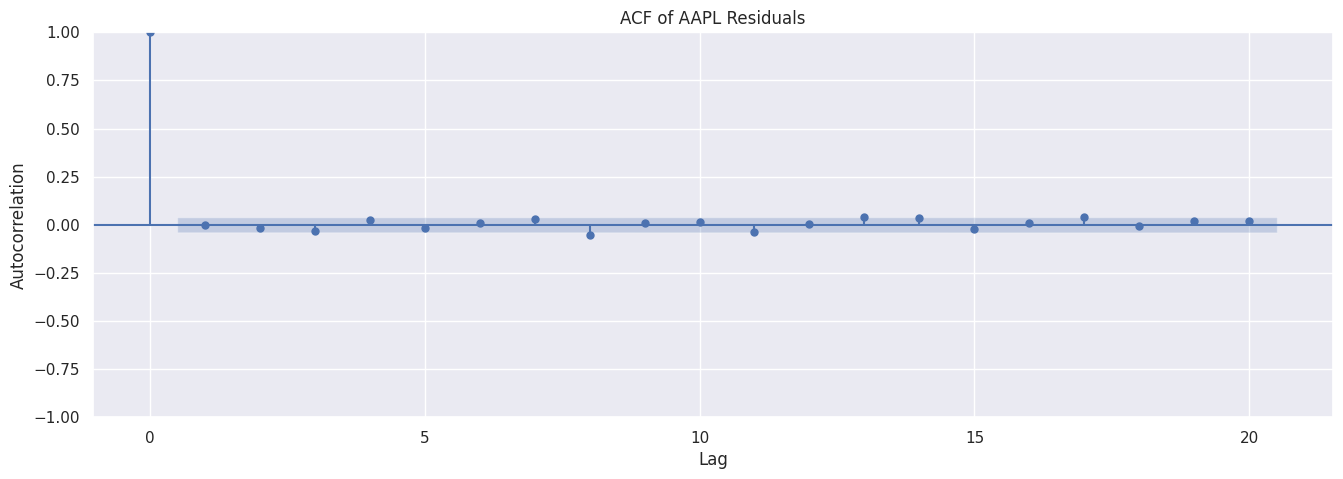

In [ ]:
# Plot the ACF of the residuals
plot_acf(residuals, lags=20)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('ACF of AAPL Residuals')
plt.show()


In [ ]:
# Manually perform the Ljung-Box test
sm.stats.acorr_ljungbox(residuals, lags=[1], return_df=True)

,lb_stat,lb_pvalue
1,0.020449,0.886291


In [ ]:
# Make predictions
arma_forecast = model_results.get_forecast(len(test_df.index))
# Create a confidence interval of 90%
arma_predictions_df = arma_forecast.conf_int(alpha = 0.1)
arma_predictions_df["Predictions"] = model_results.predict(start = len(train_df), end = len(data))


In [ ]:
# Display ARMA predictions dataframe
arma_predictions_df

,lower log_returns,upper log_returns,Predictions
2515,-0.026578,0.026921,1.715218e-04
2516,-0.026718,0.026792,3.666579e-05
2517,-0.026747,0.026763,7.837954e-06
2518,-0.026754,0.026757,1.675500e-06
2519,-0.026755,0.026756,3.581675e-07
...,...,...,...
3266,-0.026755,0.026755,0.000000e+00
3267,-0.026755,0.026755,0.000000e+00
3268,-0.026755,0.026755,0.000000e+00
3269,-0.026755,0.026755,0.000000e+00


In [ ]:
arma_predictions_df.index = test_df.index

##Get the MSE and RMSE

In [ ]:
arma_mse = mean_squared_error(test_df["log_returns"], arma_predictions_df["Predictions"])
print("ARMA MSE:", arma_mse)
print("ARMA RMSE:", np.sqrt(arma_mse))

ARMA MSE: 0.0005406064441500349
ARMA RMSE: 0.023250945016279122


##Plot the predictions

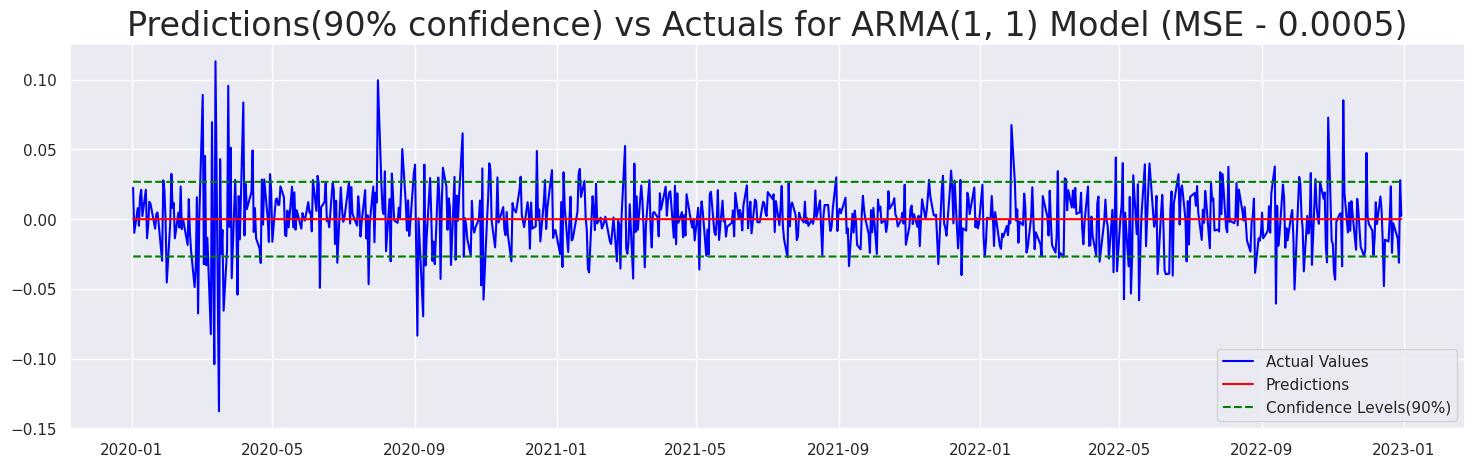

In [ ]:
plt.rcParams["figure.figsize"] = 18, 5
plt.plot(test_df["log_returns"], color = "blue", label = "Actual Values")

plt.plot(arma_predictions_df["Predictions"], color = "red", label = "Predictions")
plt.plot(arma_predictions_df["upper log_returns"], color = "green", linestyle = "--", label = "Confidence Levels(90%)")
plt.plot(arma_predictions_df["lower log_returns"], color = "green", linestyle = "--")

plt.title(f"Predictions(90% confidence) vs Actuals for ARMA(1, 1) Model (MSE - {(np.round(arma_mse, 4))})", size = 24)
plt.legend()
plt.show()

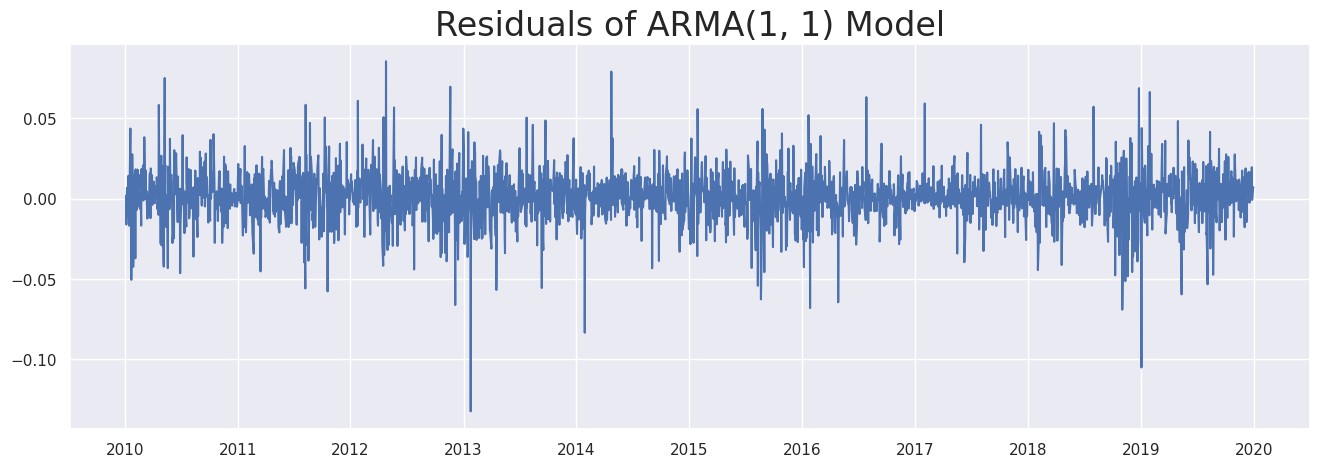

In [ ]:
#Plotting Residuals of ARMA(1,1) Model
plt.rcParams["figure.figsize"] = 16, 5
plt.plot(model_results.resid)
plt.title("Residuals of ARMA(1, 1) Model", size = 24)

plt.show()

Thanks to this plot we can observe that the variance varies with time, thus further modeling it with a GARCH model seems a reasonable option.

# ARMA-GARCH

ARMA-GARCH is an hybrid model which combines two separate ones: the autoregressive moving average (ARMA) model for the mean component and the generalized autoregressive conditional heteroskedasticity (GARCH) model for the volatility component.

                               SARIMAX Results                                
Dep. Variable:            log_returns   No. Observations:                 2515
Model:                 ARIMA(1, 0, 1)   Log Likelihood                6794.026
Date:                Sun, 11 Jun 2023   AIC                         -13580.053
Time:                        14:39:15   BIC                         -13556.733
Sample:                             0   HQIC                        -13571.589
                               - 2515                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.000      2.675      0.007       0.000       0.002
ar.L1          0.4957      0.746      0.664      0.507      -0.967       1.958
ma.L1         -0.4792      0.753     -0.636      0.5

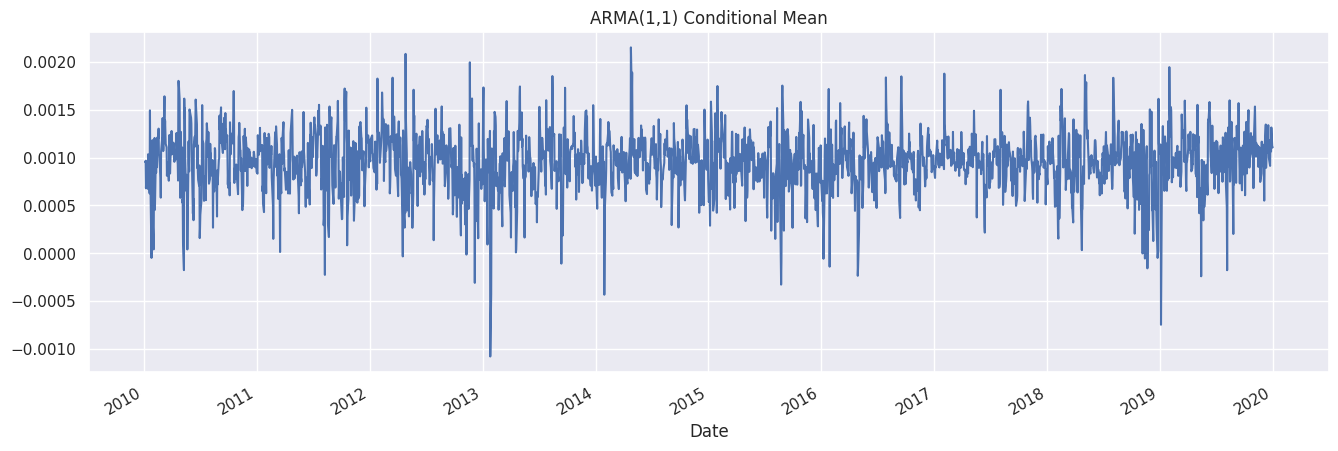

Iteration:      1,   Func. Count:      6,   Neg. LLF: 8952956703.863392
Iteration:      2,   Func. Count:     18,   Neg. LLF: -6891.525080946752
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6891.525080047013
            Iterations: 6
            Function evaluations: 18
            Gradient evaluations: 2
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                6891.53
Distribution:                  Normal   AIC:                          -13775.1
Method:            Maximum Likelihood   BIC:                          -13751.7
                                        No. Observations:                 2515
Date:                Sun, Jun 11 2023   Df Residuals:                     2514
Time:          

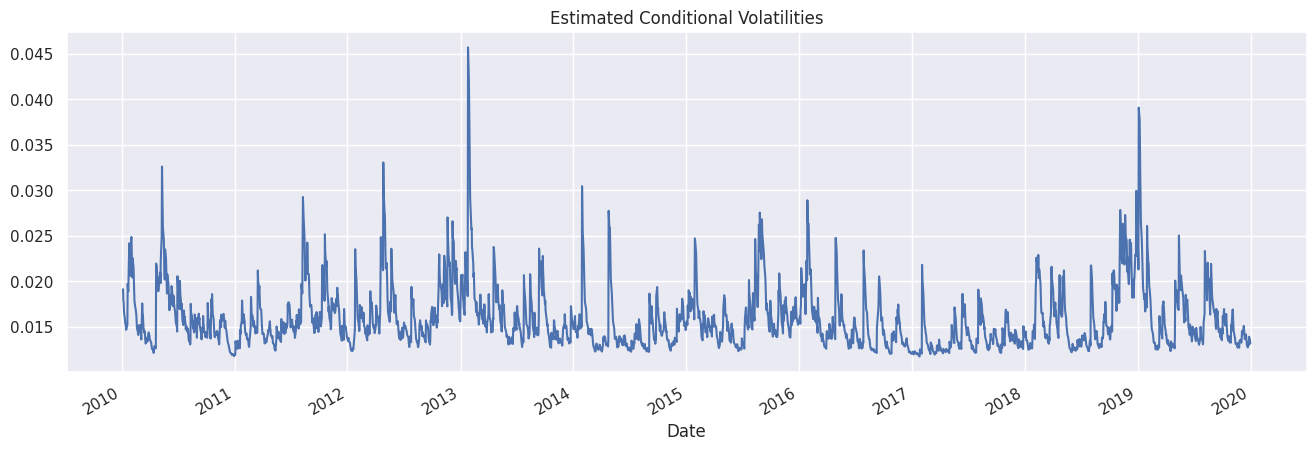

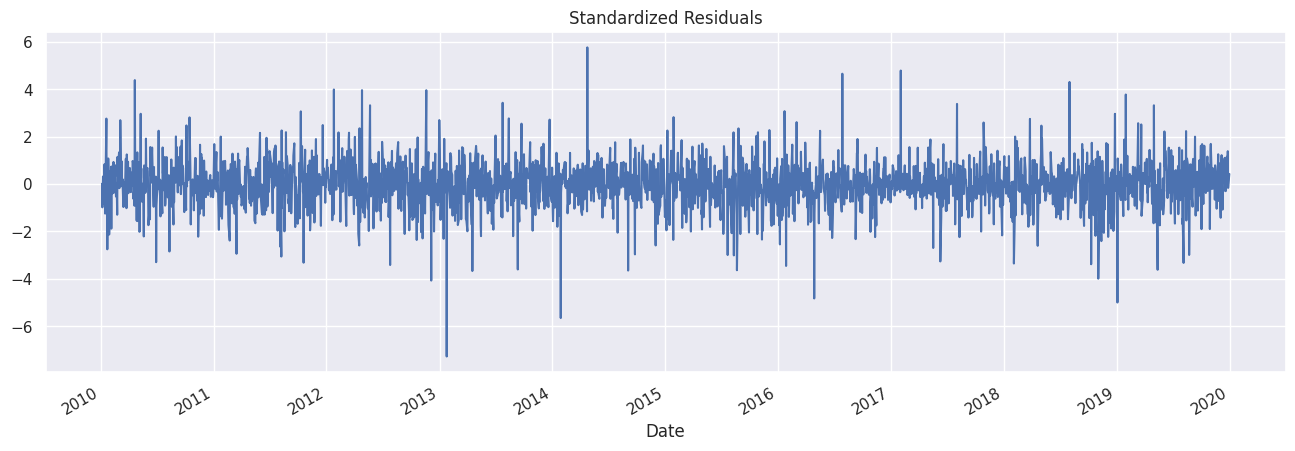

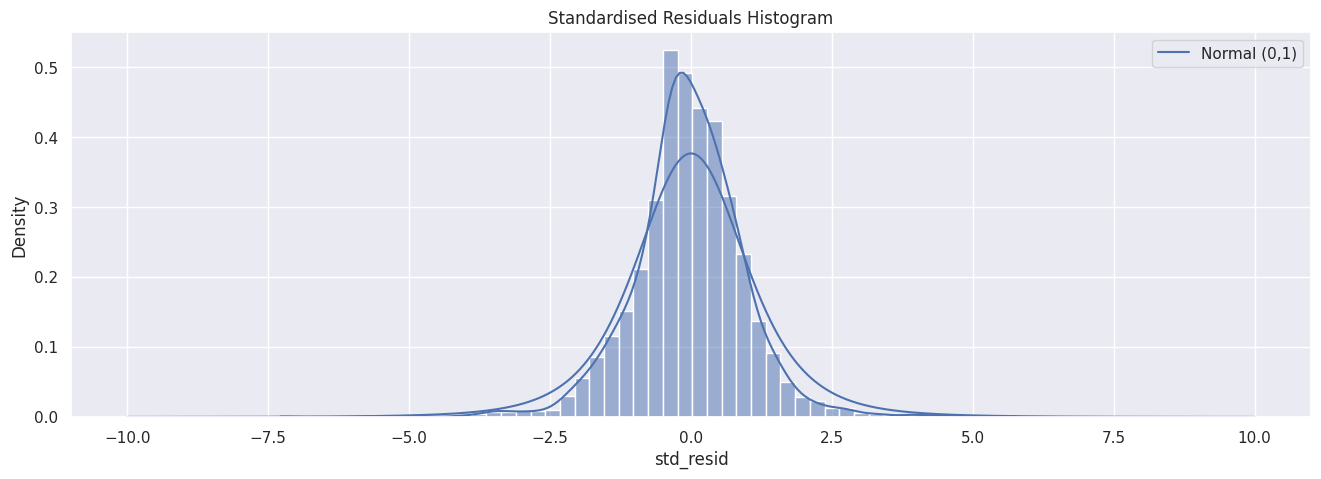

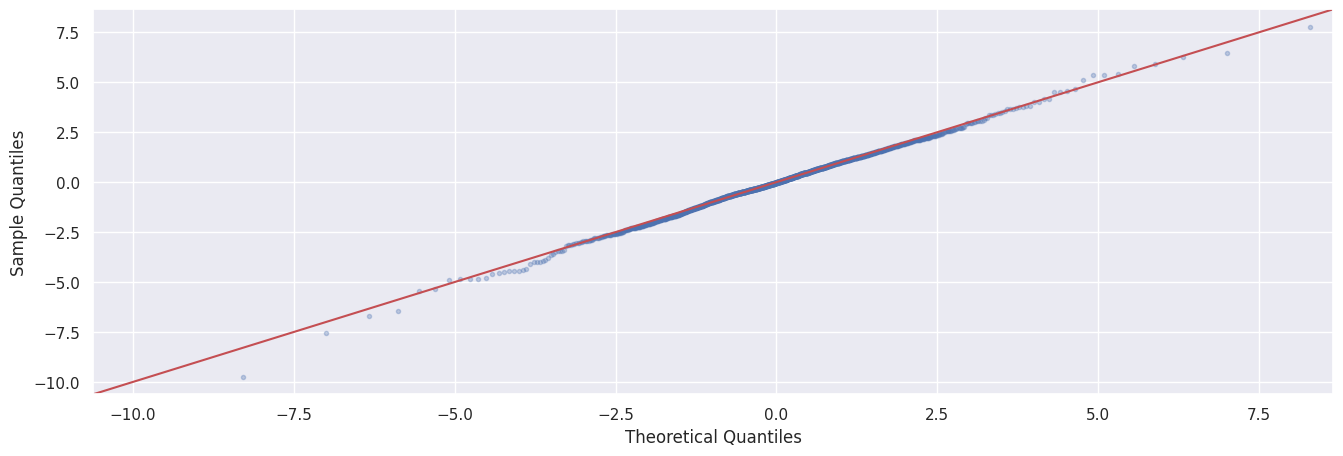

In [ ]:
#First approach: fit an ARMA and subsequently a GARCH model on the residuals, with a focus on statistical properties and plot

# Fitting an ARMA(1,1) Process to the Log_returns
arma = ARIMA(train_df, order = (1,0,1))
results = arma.fit()
residuals = results.resid
print(results.summary())
fitted_vals = results.fittedvalues

# Plotting the Conditional Mean of the ARMA(1,1) Component
fitted_vals.plot(title = "ARMA(1,1) Conditional Mean")
plt.show()

# Fitting a GARCH(1,1) Process to the residuals
garch = arch_model(residuals, p = 1, q = 1, vol = "GARCH")
result2 = garch.fit()
print(result2.summary())

# Plotting the ARMA(1,1) - GARCH(1,1) Results
# Conditional Volatilities
fig = result2.conditional_volatility.plot(title = "Estimated Conditional Volatilities")
plt.show()

# Std Residuals
fig1 = result2.std_resid.plot(title = "Standardized Residuals") # viz
plt.show()

sns_ax = sns.histplot(result2.std_resid, bins=50, stat="density", kde=True) # histogram with kde and fitted normal
sns_ax.set_title("Standardised Residuals Histogram")
params = sc.stats.t.fit(result2.std_resid)
sns_ax.plot(x,sc.stats.t.pdf(x, params[0]),label=f"Normal (0,1)")
plt.legend()
plt.show()

pp = sm.ProbPlot(result2.std_resid, fit=True, dist = sc.stats.t) # qqplot
qq = pp.qqplot(marker='.', markerfacecolor='b', markeredgecolor='b', alpha=0.3)
sm.qqline(qq.axes[0], line='45', fmt='r')
plt.show()

1. **Standardized residuals plot**, if the model is working correctly, there should be no obvious pattern in the residuals, they should be scattered.
2. **Histogram and Density plot**, it shows the distribution fo the residuals, if the model is good, the orange and green line should be almost the same.
3. **Q-Q plot**, it compares the distributionof the residuals to a normal distribution, if the residuals are normally distributed, all the points should lie across the the red line.
4. **Correlogram plot**, is the ACF plot of the residuals rather than the data, the model is doing well as long as the graph stays within the shaded area.

In [ ]:
# Second approach: get residuals and use them to make forecasts
resid_df = data.copy() # make a copy of original data
resid_df["log_returns_resid"] = resid_df["log_returns"].loc[resid_df.index]
resid_df["log_returns_resid"].loc[train_df.index] = model_results.resid

In [ ]:
resid_df

,log_returns,log_returns_resid
Date,,
2010-01-05,0.001728,0.001728
2010-01-06,-0.016034,-0.016069
2010-01-07,-0.001850,-0.001536
2010-01-08,0.006626,0.006724
2010-01-11,-0.008861,-0.008974
...,...,...
2022-12-23,-0.002802,-0.002802
2022-12-27,-0.013976,-0.013976
2022-12-28,-0.031166,-0.031166


In [ ]:
# Fit the GARCH model
resid_model = arch_model(resid_df["log_returns_resid"], p = 1, q = 1, vol = "GARCH")
resid_model_results = resid_model.fit(last_obs = test_df.index[0])
resid_model_results.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 9077173339.941425
Iteration:      2,   Func. Count:     19,   Neg. LLF: 24342.24489609858
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6891.790426535677
            Iterations: 2
            Function evaluations: 26
            Gradient evaluations: 2


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:      log_returns_resid   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                6891.79
Distribution:                  Normal   AIC:                          -13775.6
Method:            Maximum Likelihood   BIC:                          -13752.3
                                        No. Observations:                 2515
Date:                Sun, Jun 11 2023   Df Residuals:                     2514
Time:                        14:39:19   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         1.5633e-03  3.129e-04      4.997  5.821e-07 [9.502e-04,2.177e-03]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      2.6362e-05  8.297e-07     31.774 1.490e-221 [2.474e-05,2.799e-05]
alpha[1]       0.1000  1.964e-02      5.093  3.531e-07   [6.151e-02,  0.138]
beta[1]        0.8000  1.600e-02     49.987      0.000     [  0.769,  0.831]
============================================================================

Covariance estimator: robust
"""

In [ ]:
resid_forecasts = resid_model_results.forecast().residual_variance
resid_forecasts = resid_forecasts.loc[test_df.index].values

In [ ]:
resid_forecasts.shape

(756, 1)

In [ ]:
# Get the predictions from ARMA-GARCH model
arma_garch_predictions_df = arma_predictions_df.copy().loc[test_df.index]
arma_garch_predictions_df["lower log_returns"] = arma_garch_predictions_df["Predictions"] - np.sqrt(resid_forecasts.reshape(-1,))*1.65
arma_garch_predictions_df["upper log_returns"] = arma_garch_predictions_df["Predictions"] + np.sqrt(resid_forecasts.reshape(-1,))*1.65

In [ ]:
arma_garch_predictions_df

,lower log_returns,upper log_returns,Predictions
Date,,,
2020-01-02,-0.023465,0.023808,1.715218e-04
2020-01-03,-0.023494,0.023567,3.666579e-05
2020-01-06,-0.022922,0.022938,7.837954e-06
2020-01-07,-0.022429,0.022432,1.675500e-06
2020-01-08,-0.023036,0.023037,3.581675e-07
...,...,...,...
2022-12-23,-0.029943,0.029943,0.000000e+00
2022-12-27,-0.029236,0.029236,0.000000e+00
2022-12-28,-0.032361,0.032361,0.000000e+00


[]

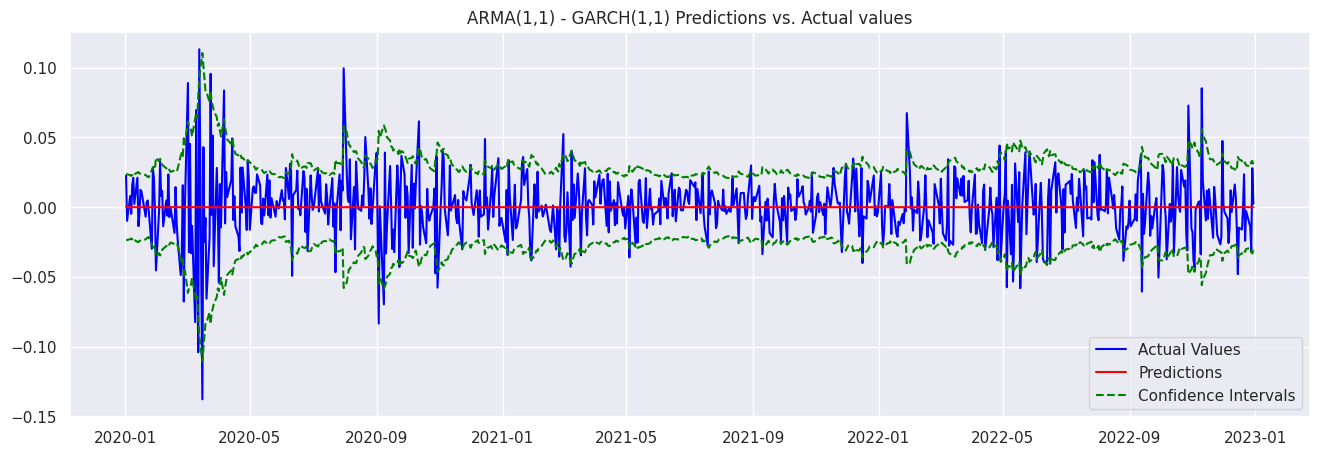

In [ ]:
# Plot the results
plt.rcParams["figure.figsize"] = 16, 5

plt.plot(test_df["log_returns"], color = "blue", label = "Actual Values")
plt.plot(arma_garch_predictions_df["Predictions"], color = "red", label = "Predictions")
plt.plot(arma_garch_predictions_df["lower log_returns"], color = "green", linestyle = "--", label = "Confidence Intervals")
plt.plot(arma_garch_predictions_df["upper log_returns"], color = "green", linestyle = "--")
plt.title("ARMA(1,1) - GARCH(1,1) Predictions vs. Actual values")
plt.legend()
plt.plot()

# Rolling window Forecast

In [ ]:
# Define look_back and look_forward variables
look_back = 60
look_forward = 7

times_exploded = []
forecasts = []
for i in range(len(data)- look_back - look_forward):
  model = SARIMAX(data.iloc[i : i + look_back], order = (1,0,1))
  results = model.fit()
  hist = results.forecast(steps = look_forward)
  times_exploded.append(data.index[i + look_back : i + look_back + look_forward])
  forecasts.append(hist.values)  # store the forecasts


In [ ]:
y_pred = forecasts[0]

# Plot stacked results

To better understand how the rolling window works, we plot three windows picked at random, illustrating the data, the predictions made by the model and the corresponding test data.

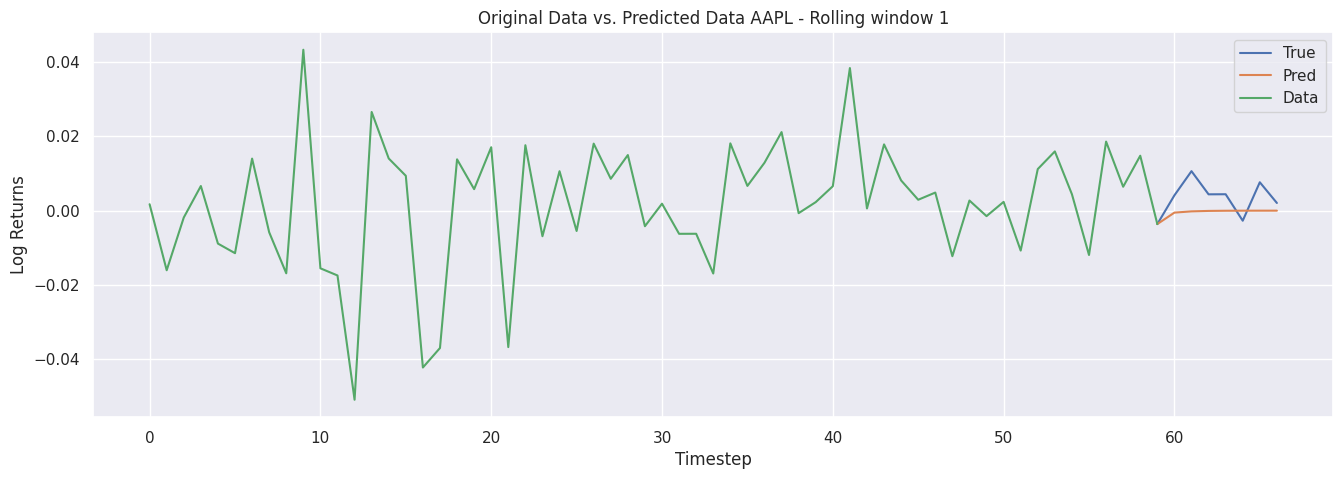

In [ ]:
# Plot
plt.plot(list(range(look_back -1,look_back + look_forward)), data.iloc[look_back - 1: look_back + look_forward] , label = 'True')
plt.plot(list(range(look_back -1, look_back + look_forward)), np.insert(forecasts[0], 0, data.iloc[look_back-1]) ,  label='Pred')
plt.plot(list(range(0, look_back)), data.iloc[0: look_back] , label='Data')


# Set plot labels and title
plt.xlabel('Timestep')
plt.ylabel('Log Returns')
#plt.xlim(40,67)

plt.title('Original Data vs. Predicted Data AAPL - Rolling window 1')

# Add legend
plt.legend()

# Display the plot
plt.show()

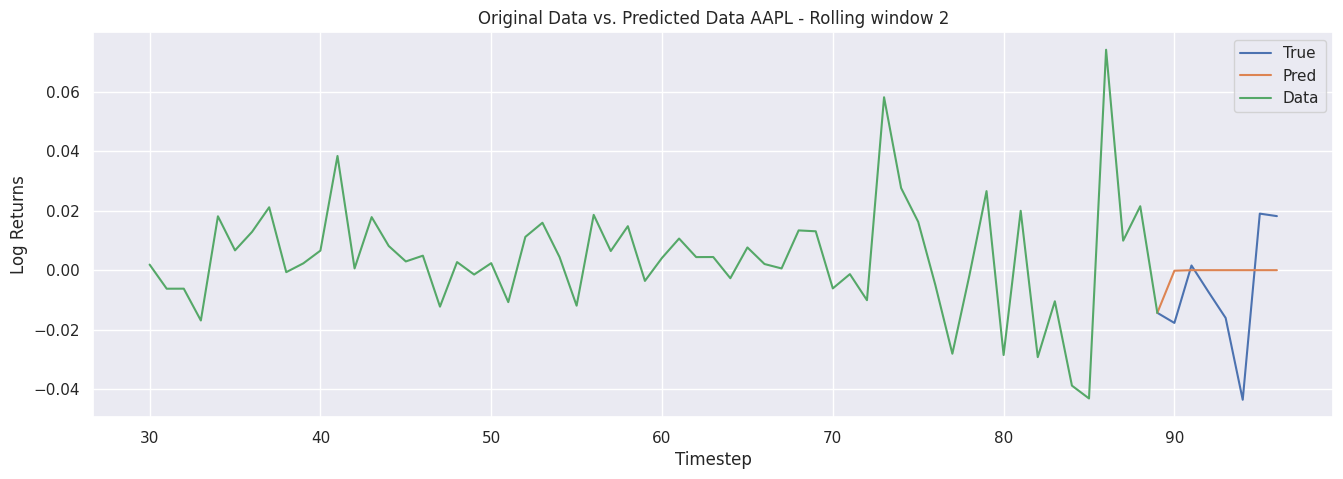

In [ ]:
# Plot
plt.plot(list(range(30 + look_back -1, 30 + look_back + look_forward)), data.iloc[30 + look_back - 1: 30 + look_back + look_forward] , label = 'True')
plt.plot(list(range(30 + look_back -1, 30 + look_back + look_forward)), np.insert(forecasts[30], 0, data.iloc[30 + look_back-1]) ,  label='Pred')
plt.plot(list(range(30, 30 + look_back)), data.iloc[30: 30 + look_back] , label='Data')


# Set plot labels and title
plt.xlabel('Timestep')
plt.ylabel('Log Returns')
#plt.xlim(40,67)

plt.title('Original Data vs. Predicted Data AAPL - Rolling window 2')

# Add legend
plt.legend()

# Display the plot
plt.show()

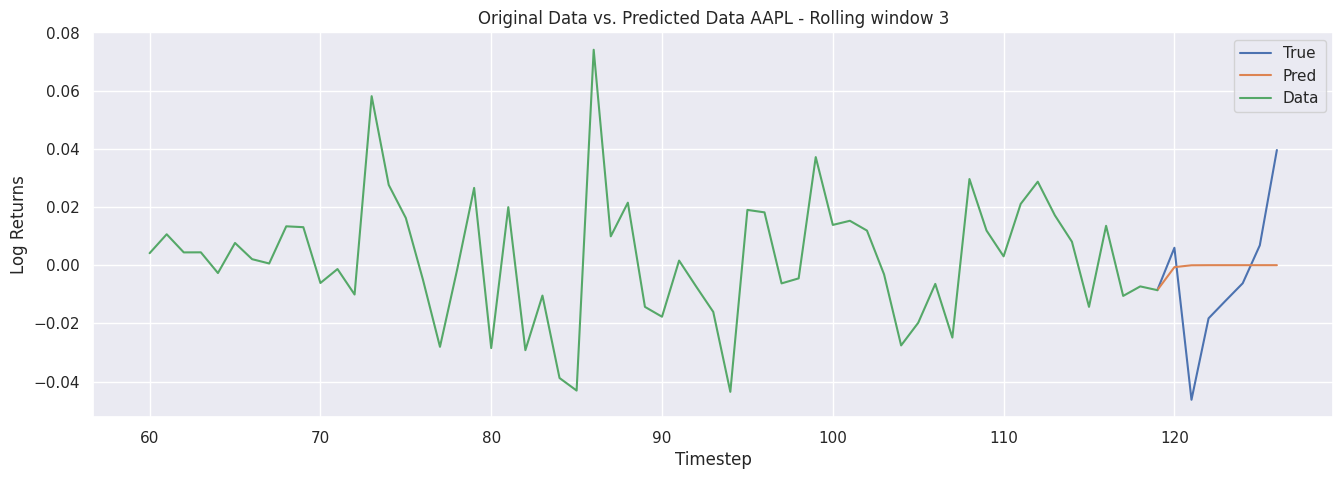

In [ ]:
# Plot
plt.plot(list(range(60+ look_back -1, 60 +look_back + look_forward)), data.iloc[60 + look_back - 1: 60 + look_back + look_forward] , label = 'True')
plt.plot(list(range(60 + look_back -1, 60 + look_back + look_forward)), np.insert(forecasts[60], 0, data.iloc[60 + look_back-1]) ,  label='Pred')
plt.plot(list(range(60, 60 + look_back)), data.iloc[60: 60 + look_back] , label='Data')


# Set plot labels and title
plt.xlabel('Timestep')
plt.ylabel('Log Returns')
#plt.xlim(40,67)

plt.title('Original Data vs. Predicted Data AAPL - Rolling window 3')

# Add legend
plt.legend()

# Display the plot
plt.show()

# Plot rolling windows

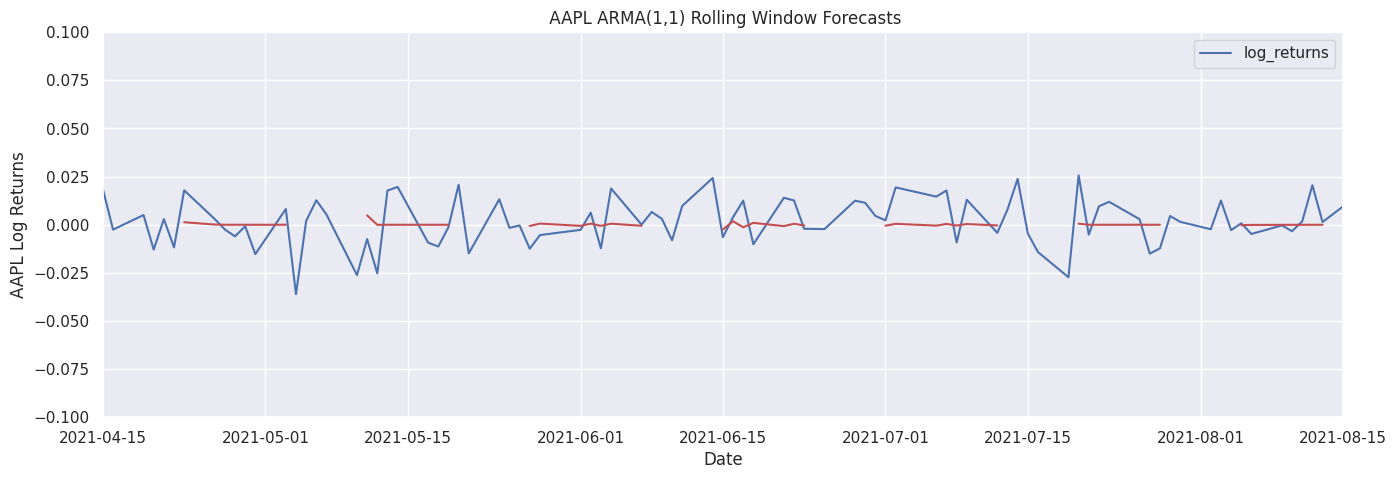

In [ ]:
times_exploded = np.array(times_exploded)
forecasts = np.array(forecasts)

# Plot the actual data
plt.plot(data.index[look_back + look_forward:], data[look_back + look_forward:], label="log_returns")


# Plot the forecasts
for i in range(2700, len(forecasts), 12):
    plt.plot(times_exploded[i], forecasts[i], color = 'r')


# Add labels and title to the plot
plt.xlabel("Date")
plt.ylabel("AAPL Log Returns")
plt.title(" AAPL ARMA(1,1) Rolling Window Forecasts")
plt.xlim(pd.Timestamp('2021-04-15'), pd.Timestamp('2021-08-15'))
plt.ylim(-0.1,0.1)
# Add legend
plt.legend()

# Show the plot
plt.show()
